<div style="text-align: center;">

# MCMC Project

## Bayesian Time Series Analysis of Air Pollution in Delhi 



#### Srishti Lakhotia | MDS202437
#### Supervised by Prof. M. R. Srinivasan</div>


# 1. Introduction

Air quality monitoring and prediction play a vital role in public health management, environmental policy, and urban planning across India’s rapidly growing metropolitan regions. The Air Quality Index (AQI) provides a standardized measure of air pollution levels and their health implications. Delhi, in particular has become among the worst highly urban regions to live in according to AQI levels. 

## 1.1 Why Bayesian?

Traditional time series models and frameworks face limitations in quantifying uncertainty, capturing complex temporal dependencies, and integrating prior knowledge of pollution dynamics. Bayesian methods offer a principled alternative, enabling explicit uncertainty modeling, incorporation of domain-specific priors, and probabilistic forecasting with credible intervals. This project employs Bayesian time series inference using Markov Chain Monte Carlo (MCMC) techniques to model and predict AQI trends in these cities, enhancing interpretability and decision-making compared to classical approaches.

## 1.2 AQI

The **Air Quality Index (AQI)** is a standardized numerical scale (typically 0–500) used to report daily air quality. It converts measured pollutant concentrations into a single value that reflects how hazardous the air is to human health.

### 1.2.1 Formula for AQI

For each pollutant *p*, AQI is computed using the EPA linear piecewise equation:

$$
AQI_p = \frac{I_{\text{high}} - I_{\text{low}}}{C_{\text{high}} - C_{\text{low}}} (C_p - C_{\text{low}}) + I_{\text{low}}
$$

Where:

- $C_p$: measured concentration of pollutant *p*  
- $C_{\text{low}}, C_{\text{high}}$: breakpoints that bound $C_p$  
- $I_{\text{low}}, I_{\text{high}}$: corresponding AQI breakpoints  
- Overall AQI = max of all $AQI_p$ values across pollutants

$$
AQI = \max(AQI_{PM2.5}, AQI_{PM10}, AQI_{O_3}, AQI_{NO_2}, AQI_{SO_2}, AQI_{CO})
$$

### 1.2.2 The Problem with AQI

1. **AQI is not a physical measurement.**  
   It is a *nonlinear transformation* applied to pollutant concentrations, which themselves are governed by meteorology, emissions, and chemistry. The AQI scale introduces discontinuities at breakpoint boundaries.

2. **AQI depends on the maximum of several pollutants.**  
   Because AQI = max of individual pollutant AQIs, small changes in any pollutant can abruptly change the final AQI. This creates a highly irregular mapping that models struggle with.

3. **Breakpoints vary by pollutant and are piecewise.**  
   The AQI value is computed using different linear segments depending on which interval a pollutant falls into. This creates a function that is:
   - piecewise,
   - nonlinear overall,
   - non-invertible.

4. **Loss of information.**  
   AQI compresses multiple pollutant signals into one number. Predicting that one compressed value eliminates useful patterns in the underlying data.

_Thus, instead of AQI, here, we will model individual pollutants (PM2.5, PM10, SO2, CO, etc.) as they vary with time._

### 1.2.3 Why model pollutant concentrations instead

1. **Pollutants follow physical, chemical, and meteorological processes**  
   These processes produce smoother and more predictable relationships than the AQI transformation.

2. **Models can use continuous, unbounded data**  
   Raw concentrations vary continuously without piecewise breakpoints, making them easier for regression or ML models to learn.

3. **Better interpretability**  
   Modeling concentrations allows you to answer questions like “What is driving poor air quality?” which AQI alone cannot reveal.




In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error
from scipy.stats import invgamma
from statsmodels.tsa.stattools import adfuller, acf


# 2. Data

The data has been sourced from the [Central Pollution Control Board (CPCB)](https://airquality.cpcb.gov.in/ccr/#/caaqm-dashboard-all/caaqm-landing/aqi-repository) and [World Air Quality Index project](https://aqicn.org/city/delhi/mandir-marg/). 

We have time series data of AQI from **2018 to 2025** and data on 6 individual pollutants (PM2.5, PM10, O3, NO2, SO2, CO) from **2014 to 2025**. 

# 3. EDA

In [2]:
df = pd.read_csv('mandir-marg, delhi-air-quality.csv', skipinitialspace=True)

## 3.1 EDA on pollutant data

### 3.1.1 Checking for missing values

In [3]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort by date
df = df.sort_values('date')

# Check for duplicates
print(f"Number of duplicate dates: {df['date'].duplicated().sum()}")

# Check missing values count
missing_counts = df.isnull().sum()
print("\nMissing Values Count:")
print(missing_counts)

# Extract year and month for seasonality analysis
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['month_name'] = df['date'].dt.month_name()

# Set date as index for easier plotting
df_ts = df.set_index('date')

df.replace(999, np.nan, inplace=True) # Generally error codes
df_ts.replace(999, np.nan, inplace=True)

df.reset_index(drop=True, inplace=True)

Number of duplicate dates: 0

Missing Values Count:
date      0
pm25    101
pm10     70
o3      102
no2      97
so2     359
co      118
dtype: int64


### 3.1.2 Plots of pollutants w.r.t time

Note: All concetrations are in $𝜇𝑔/𝑚^3$.


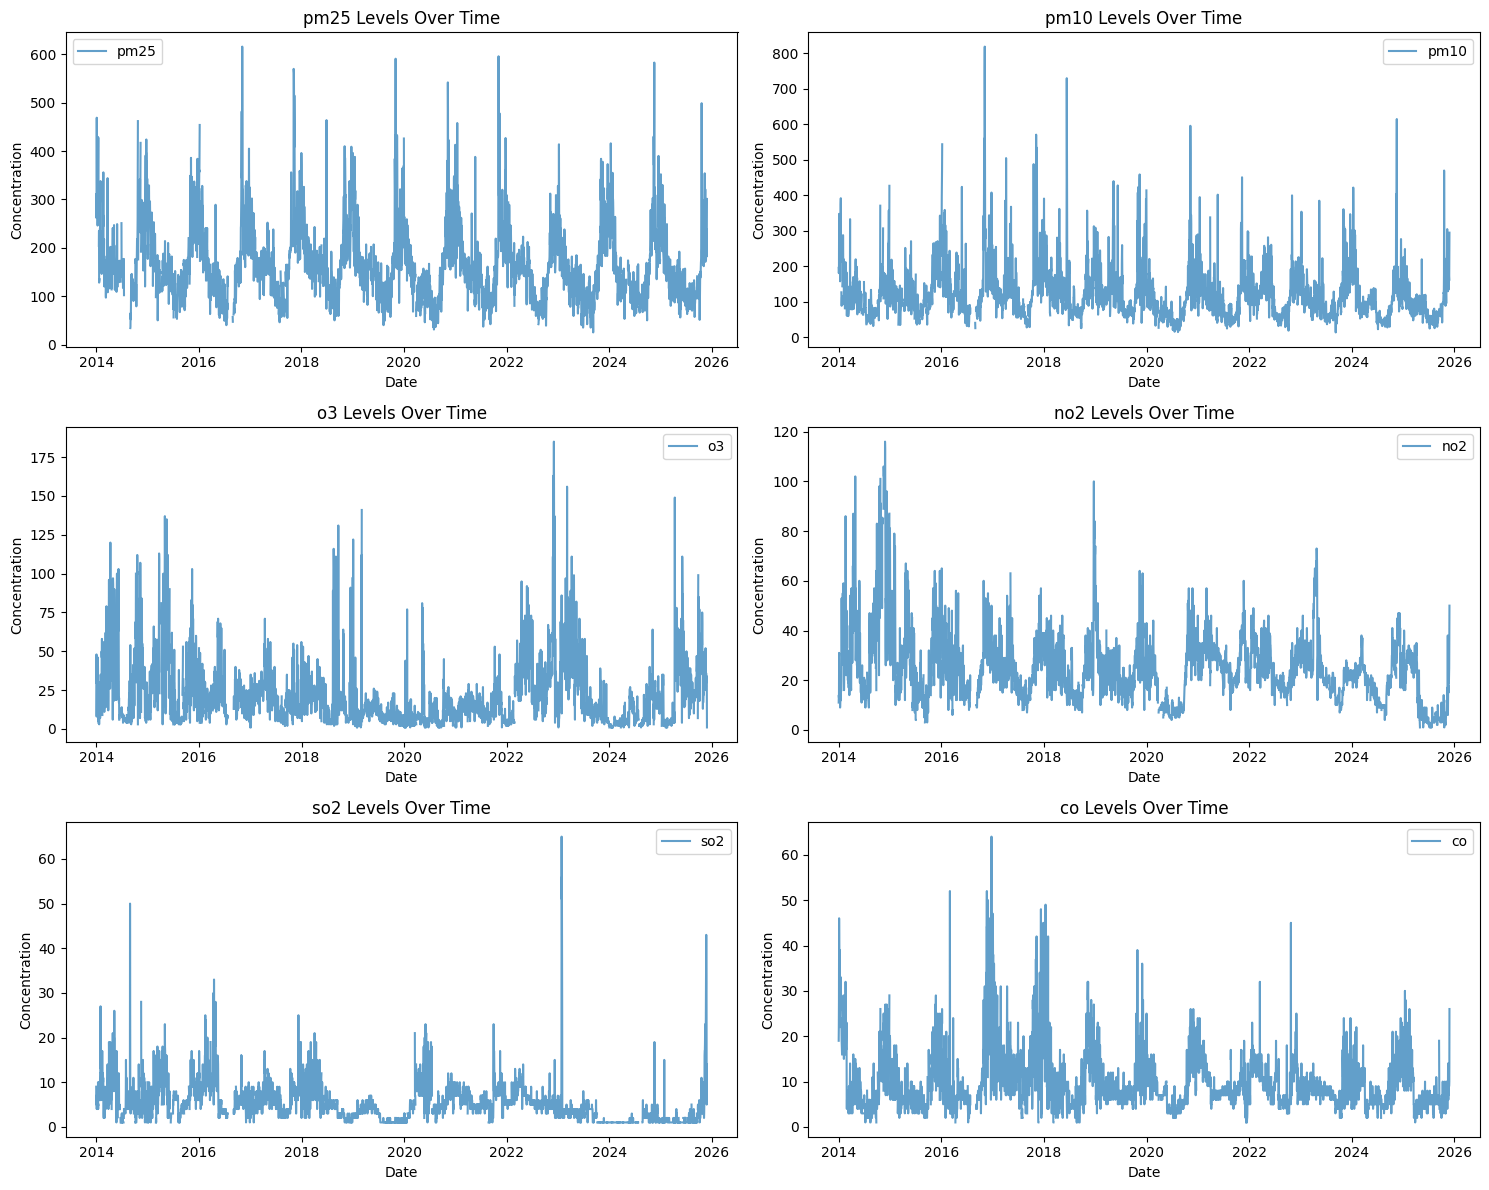

In [ ]:
pollutants = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']

plt.figure(figsize=(15, 12))
for i, col in enumerate(pollutants):
    plt.subplot(3, 2, i+1)
    plt.plot(df_ts.index, df_ts[col], label=col, alpha=0.7)
    plt.title(f'{col} Levels Over Time')
    plt.xlabel('Date')
    plt.ylabel('Concentration')
    plt.legend()

plt.tight_layout()
plt.savefig('timeseries_pollutants.png')

All pollutants seem to follow a cyclical pattern. Particulate matter patterns, especially PM2.5 do not seem to change even during the COVID-19 times whereas most other pollutants show a drop during 2020-21 but jump right backsoon after.

### 3.1.3 Distribution of pollutants

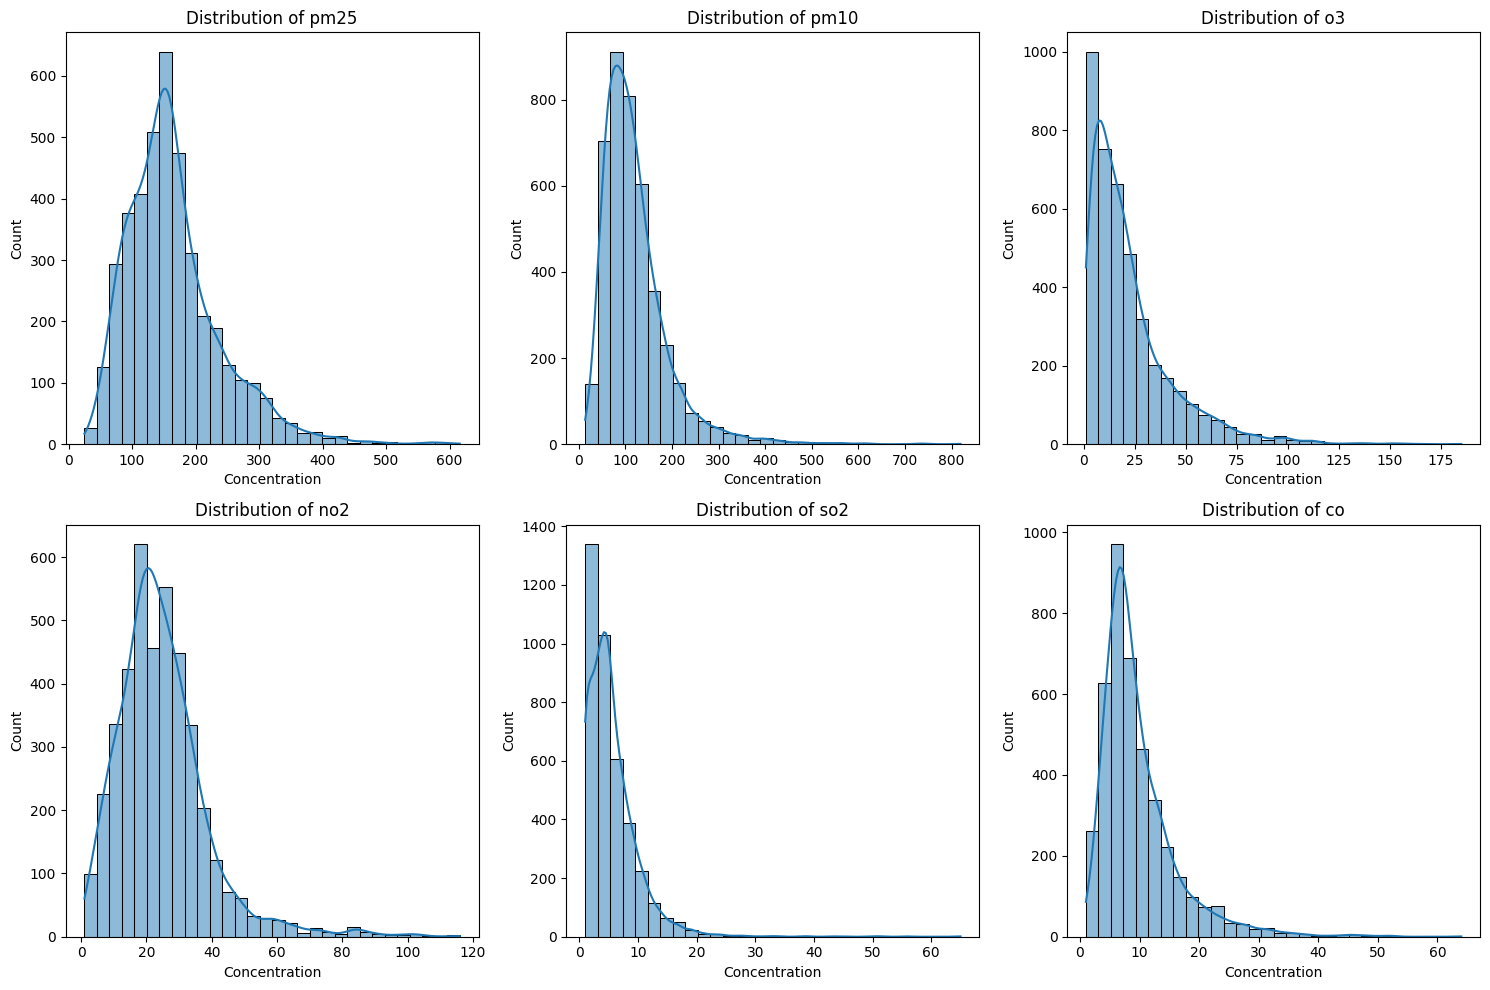

In [13]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(pollutants):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Concentration')

plt.tight_layout()
plt.savefig('distributions.png')

All pollutant distributions are positively skewed and seem to deviate heavily from normality.

### 3.1.4 Correlation between pollutants

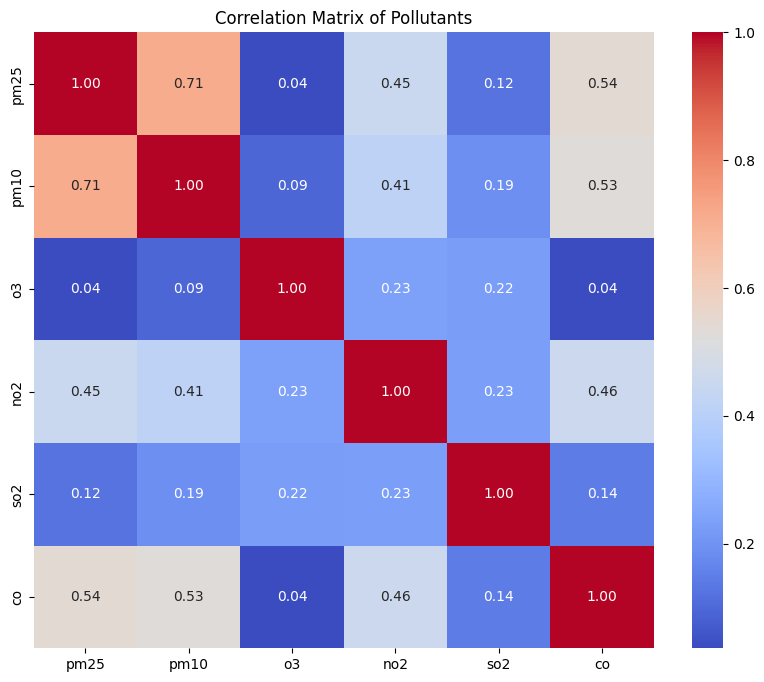

In [12]:
plt.figure(figsize=(10, 8))
corr = df[pollutants].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Pollutants')
plt.savefig('correlation_matrix.png')

Clearly, and as expected, strong correlation exists between most pairs of pollutants.

## 3.2 EDA on AQI 

### 3.2.1 Plot of AQI vs Time

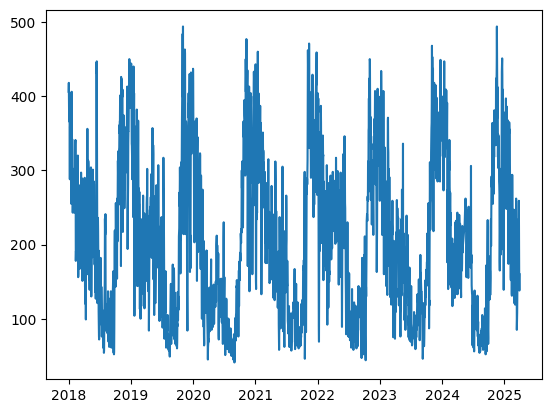

In [24]:
merged_df = pd.read_csv("merged_df.csv")
merged_df["date"] = pd.to_datetime(merged_df['date'])
plt.plot(merged_df["date"], merged_df["AQI"])
#plt.show()

The cyclical pattern seen in the pollutants is also seen here.

### 3.2.3 Distribution of AQI

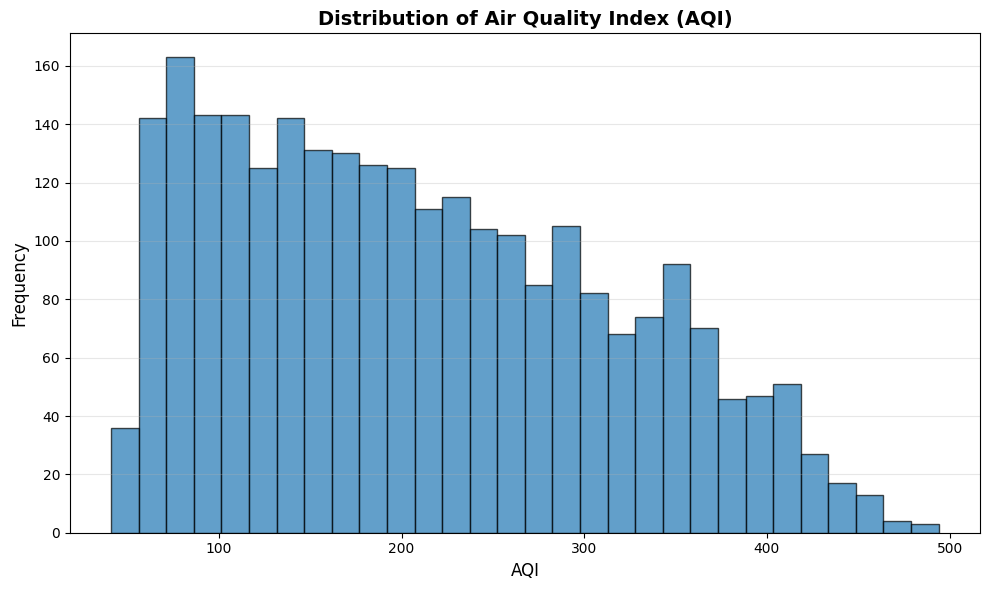

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(merged_df['AQI'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('AQI', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Air Quality Index (AQI)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

This plot is much flatter, has less of a bell shape, likely due to the fact that it is a max over individually computed AQI w.r.t each pollutant.

# 4. Regressing AQI vs Pollutants

To find which pollutants dominate the AQI in Delhi, we perform a simple Linear Regression between AQI and pollutant values.



In [5]:
merged_df = pd.read_csv("merged_df.csv")

# Define predictors (pollutants) and response (AQI)
predictor_columns = ['pm25', 'pm10', 'o3', 'so2', 'co']

# Create a clean dataset with no missing values: using forward fill for ts data
regression_df = merged_df[predictor_columns + ['AQI']].ffill()

# Prepare data for regression
X = regression_df[predictor_columns]
y = regression_df['AQI']

# Add constant term for intercept
X = sm.add_constant(X)

# Fit OLS model
model = OLS(y, X)
results = model.fit()

# Display comprehensive summary
print("\n" + "="*60)
print("OLS REGRESSION RESULTS")
print("="*60)
print(results.summary())


OLS REGRESSION RESULTS
                            OLS Regression Results                            
Dep. Variable:                    AQI   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     2341.
Date:                Mon, 01 Dec 2025   Prob (F-statistic):               0.00
Time:                        01:35:12   Log-Likelihood:                -13690.
No. Observations:                2623   AIC:                         2.739e+04
Df Residuals:                    2617   BIC:                         2.743e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8533      2

While all pollutants in our data are significant, direct interpretation of this linear regression is difficult due to extremely high multicollinearity that exists between these predictors in real-life. However, the model does tell us that PM2.5 drives the AQI very often. This is very often seen in cities such as Delhi where PM2.5 and PM10 in general define the AQI. Thus, as a proxy for air pollution, **we model the PM2.5 series**.

# 5. EDA on PM2.5 series

PM2.5 values contain a few NaNs, which we can interpolate. 

## 5.1.1 TS decompostion

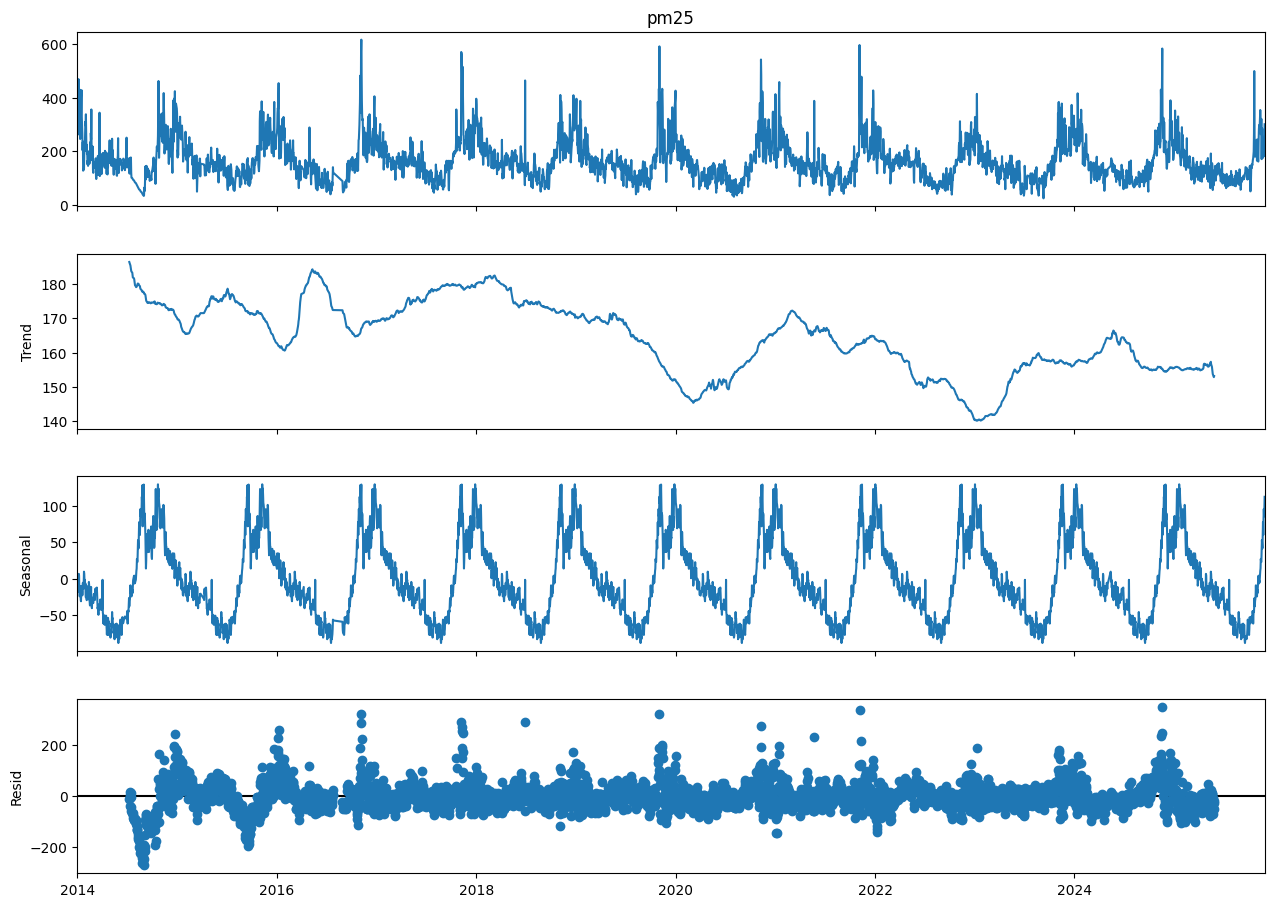

In [25]:
pm25_interpolated = df_ts['pm25'].interpolate(method='linear', limit_direction='both')

# Seasonal Decomposition 
try:
    decomposition = seasonal_decompose(pm25_interpolated, model='additive', period=365)
    fig = decomposition.plot()
    fig.set_size_inches(14, 10)
    plt.savefig('decomposition_pm25_fixed.png')
except Exception as e:
    print(f"Decomposition failed again: {e}")

In [4]:
pm25_interpolated = pd.read_csv("interpolated_data.csv")

### 5.1.2 ACF, PACF Plots

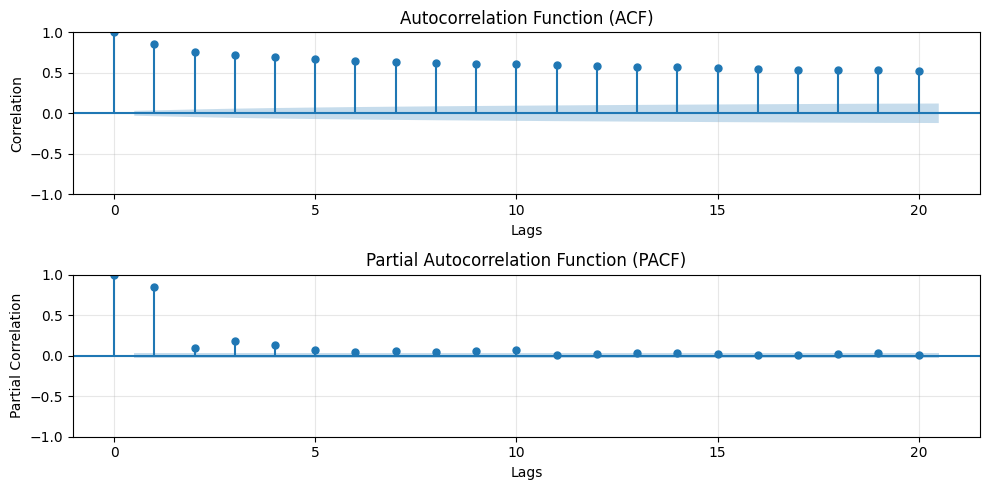

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

lags = 20

# 1. Plot Autocorrelation Function (ACF)
plot_acf(pm25_interpolated['pm25'], ax=ax1, lags=lags)
ax1.set_title('Autocorrelation Function (ACF)')
ax1.set_xlabel('Lags')
ax1.set_ylabel('Correlation')
ax1.grid(True, alpha=0.3)

# 2. Plot Partial Autocorrelation Function (PACF)
plot_pacf(pm25_interpolated['pm25'], ax=ax2, lags=lags)
ax2.set_title('Partial Autocorrelation Function (PACF)')
ax2.set_xlabel('Lags')
ax2.set_ylabel('Partial Correlation')
ax2.grid(True, alpha=0.3)

plt.tight_layout()

output_filename = 'acf_pacf_plots.png'
plt.savefig(output_filename)

plt.show()

ACF (Autocorrelation Function): The plot shows a very slow, linear decay. This is the classic signature of a non-stationary time series. The high correlation persists for many lags, indicating that the current value is strongly dependent on the history of previous values, likely due to a trend. This confirms that differencing ($d \ge 1$) is necessary to make the data stationary.

PACF (Partial Autocorrelation Function): There is a massive spike at Lag 1 (close to 1.0) followed by a sharp cut-off. 

# 6. Baseline ARIMA Model

From the plots above, we fit a baseline ARIMA(1,1,0) model to our data.

We use data upto Oct 2025 for modelling and predict PM2.5 concentration values for Nov 2025.

## 6.1 Model Fitting

In [5]:
break_date = '2025-10-31'
train = pm25_interpolated[(pm25_interpolated['date'] <= break_date)]
test = pm25_interpolated[(pm25_interpolated['date'] > break_date)]
model = ARIMA(train["pm25"], order=(1, 1, 0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   pm25   No. Observations:                 4206
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -21447.570
Date:                Mon, 01 Dec 2025   AIC                          42899.139
Time:                        03:40:29   BIC                          42911.827
Sample:                             0   HQIC                         42903.626
                               - 4206                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1592      0.007    -21.513      0.000      -0.174      -0.145
sigma2      1577.0934     14.462    109.049      0.000    1548.748    1605.439
Ljung-Box (L1) (Q):                   5.72   Jarque-

## 6.2 Plotting the fitted model

### 6.2.1 Actual vs Fitted

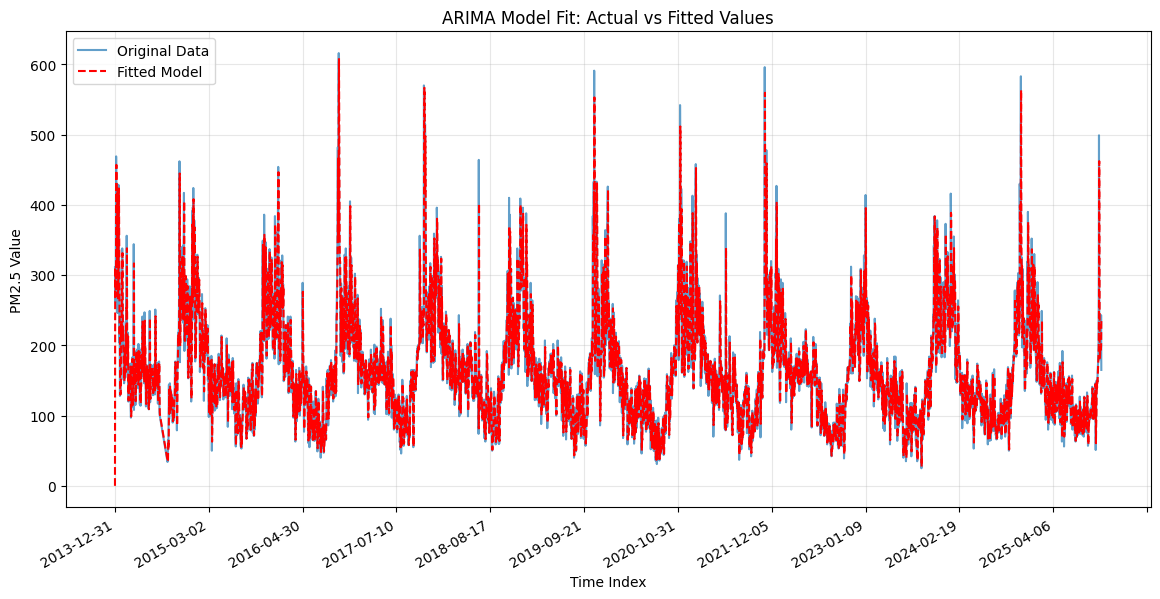

In [51]:
predictions = model_fit.predict(start=0, end=len(train["pm25"])-1, dynamic=False)
    
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.plot(train["date"], train["pm25"], label='Original Data', alpha=0.7)
ax.plot(train["date"], predictions, color='red', label='Fitted Model', linestyle='--')

ax.set_title('ARIMA Model Fit: Actual vs Fitted Values')
ax.set_xlabel('Time Index')
ax.set_ylabel('PM2.5 Value')
ax.legend()
ax.grid(True, alpha=0.3)

fig.autofmt_xdate()
    
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
plt.savefig("ARIMA model.png")
plt.show()

### 6.2.2 Residual Plot

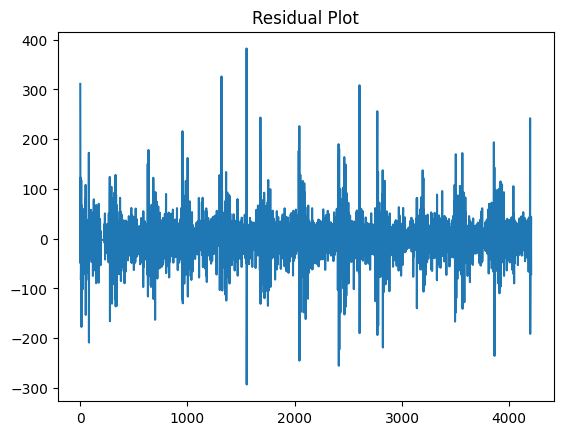

In [52]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title="Residual Plot", legend=False)
plt.show()

### 6.2.3 Interpretation

Strong Directional Fit: The model (red dashed line) does an excellent job of tracking the overall direction of the data. When the PM2.5 levels rise or fall, the model follows suit almost immediately. 
    This confirms that the previous day's value (the AR term) and the trend (the Differencing term) are strong predictors for the next day.

Underestimating Extremes (Smoothing Effect): For the very highest spikes (the sharp blue peaks), the red line often falls short. 
    This is because ARIMA models are regression-based; they tend to predict the "average" expected behavior based on past patterns. They are naturally conservative and struggle to capture sudden, extreme outliers or "shocks" unless those shocks persist for a while. For this reason, the residual values also seem to be quite huge when corresponding to spikes.

Lag/Shadowing: In some sections, the red line might appear to be slightly "late" or shifted to the right compared to the blue line.
    This is typical for AR(1) models. Since the model relies heavily on $y_{t-1}$ (yesterday's value) to predict $y_t$ (today's value), it can sometimes look like it's just repeating the previous value, resulting in a "shadowing" effect.
    
This is a good, robust baseline model. The fact that the red line captures the complex cyclic structure without needing explicit seasonality parameters suggests the autocorrelation in the data is very strong.

## 6.3 Model Forecasting

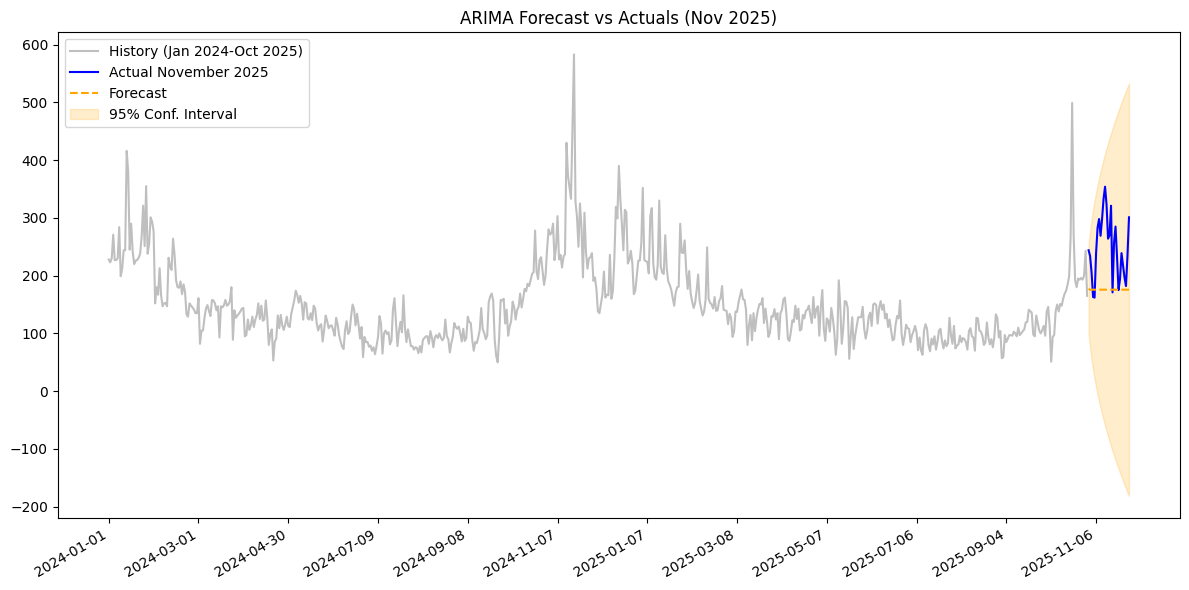

In [ ]:
future_index = test["date"]
steps = len(future_index)


forecast_res = model_fit.get_forecast(steps=steps)
mean = forecast_res.predicted_mean
ci = forecast_res.conf_int(alpha=0.05) 

temp_df = pd.DataFrame({
    'forecast': mean.values, 
    'mean_ci_lower': ci.iloc[:, 0].values, 
    'mean_ci_upper': ci.iloc[:, 1].values  
}, index=future_index)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

train_view = pm25_interpolated[(pm25_interpolated["date"] < future_index.iloc[0]) & (pm25_interpolated["date"] >= "2024-01-01")]
ax.plot(train_view["date"], train_view["pm25"], label='History (Jan 2024-Oct 2025)', color='gray', alpha=0.5)

ax.plot(test["date"], test["pm25"], label='Actual November 2025', color='blue') # ground truth
ax.plot(temp_df.index, temp_df['forecast'], label='Forecast', color='orange', linestyle='--') # prediction
ax.fill_between(temp_df.index, 
                 temp_df['mean_ci_lower'], 
                 temp_df['mean_ci_upper'], 
                 color='orange', alpha=0.2, label='95% Conf. Interval')

ax.set_title('ARIMA Forecast vs Actuals (Nov 2025)')
ax.legend()
fig.autofmt_xdate()
    
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
plt.tight_layout()
plt.show()

In [58]:
mse = mean_squared_error(test['pm25'], temp_df['forecast'])

# 3. Calculate RMSE (Square root of MSE)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse:.2f}")

RMSE: 90.02


The forecast seems to be quite poor for this particular scenario since about right where we cut off the history the next actual value is a spike, which our model fails to predict accurately.

# 7. Bayesian Modelling

## 7.1 Bayesian AR(p) Model 

A Bayesian AutoRegressive model of order *p*, AR(p), describes a stationary time series $ y_t$ using its own past values:

$$
y_t = \mu + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \varepsilon_t,
\qquad 
\varepsilon_t \sim \mathcal{N}(0, \sigma^2)
$$

In the Bayesian framework, we treat all unknown parameters  
$ \theta = \{\mu, \phi_1,\dots,\phi_p, \sigma^2\} $
as random variables with prior distributions. The data updates these priors to posteriors through Bayes' rule.

## 7.2 Gibbs Sampling 

Gibbs sampling is a Markov Chain Monte Carlo (MCMC) algorithm that samples from a joint posterior by iteratively sampling from the **full conditional distributions**.

If the posterior factorizes as:

$$
p(\theta \mid y) = 
p(\mu \mid \cdot)\,
p(\phi_1,\dots,\phi_p \mid \cdot)\,
p(\sigma^2 \mid \cdot),
$$

then Gibbs sampling cycles through:

1. **Sample the intercept**
   $$
   \mu^{(k+1)} \sim p(\mu \mid \phi^{(k)}, \sigma^{2(k)}, y)
   $$

2. **Sample the AR coefficients**
   $$
   \phi^{(k+1)} \sim p(\phi \mid \mu^{(k+1)}, \sigma^{2(k)}, y)
   $$

3. **Sample the variance**
   $$
   \sigma^{2(k+1)} \sim p(\sigma^2 \mid \mu^{(k+1)}, \phi^{(k+1)}, y)
   $$

With conjugate priors, each full conditional has a **closed-form distribution**, making Gibbs extremely simple and efficient.

## 7.3 Conjugate Priors for Bayesian AR(p)

We rewrite the AR(p) model in regression form:

$$
y_t = X_t \beta + \varepsilon_t,
\qquad
\varepsilon_t \sim \mathcal{N}(0,\sigma^2)
$$

where

- $ \beta = (\mu, \phi_1,\dots,\phi_p)^\top $
- $ X_t = (1,\ y_{t-1},\dots,y_{t-p}) $

We place the following **conjugate priors**:

**Normal prior for coefficients:**
$$
\beta \sim \mathcal{N}(\beta_0,\ V_0)
$$

**Inverse-Gamma prior for variance:**
$$
\sigma^2 \sim \text{Inverse-Gamma}(\alpha_0,\ \beta_0)
$$

These priors ensure:

- $ \beta \mid \sigma^2, y $ is Normal  
- $ \sigma^2 \mid \beta, y $ is Inverse-Gamma  

allowing a straightforward Gibbs sampler.


## 7.4 Implementation

Again, we use data till Oct 2025 for modelling and find predictions for Nov 2025.

### 7.4.1 Converting data to stationary: differencing

$BAR(p)$ models assume data to be stationary or near stationary. Thus, we perform first differencing and check for stationarity using the Augmented Dickey-Fuller Test.

In [9]:
y = train["pm25"].astype(float)
dy = y.diff().dropna()

adf_res = adfuller(dy, autolag="BIC")

print("\n--- First Difference Summary ---")
print(f"Original observations: {len(y)}, After differencing: {len(dy)}")

print("\n--- Augmented Dickey-Fuller Test on First Difference ---")
print(f"Test Statistic: {adf_res[0]}")
print(f"P-Value:        {adf_res[1]}")
print(f"Used Lags:      {adf_res[2]}")
print(f"Number of Obs:  {adf_res[3]}")
print("Critical Values:")
for k, v in adf_res[4].items():
    print(f"   {k} : {v}")


--- First Difference Summary ---
Original observations: 4206, After differencing: 4205

--- Augmented Dickey-Fuller Test on First Difference ---
Test Statistic: -31.60044262278862
P-Value:        0.0
Used Lags:      8
Number of Obs:  4196
Critical Values:
   1% : -3.4319094149161673
   5% : -2.862229063710776
   10% : -2.5671367944344836


Thus, we strongly reject the null hypothesis that a unit root is present. This gives extremely strong evidence of stationarity after first differencing.

### 7.4.2 Prior Distribution Hyperparameters and Gibbs Sampling arguments

We choose **β₀ = 0** (a vector of zeros) and **V₀ = diag(100, 100, …)**.  
By setting a **large prior variance**, the Normal prior becomes *weakly informative*, meaning it does not strongly pull the AR coefficients toward any particular values.  
This allows the **data to dominate the posterior**, while still retaining the conjugacy needed for efficient Gibbs sampling.

For the Hyperparameters w.r.t $\sigma^2$, we choose (2, 1) randomly.

We create a chain of length 10000 and discard the intial 1000 as burn-in.

### 7.4.3 Trace Plots 

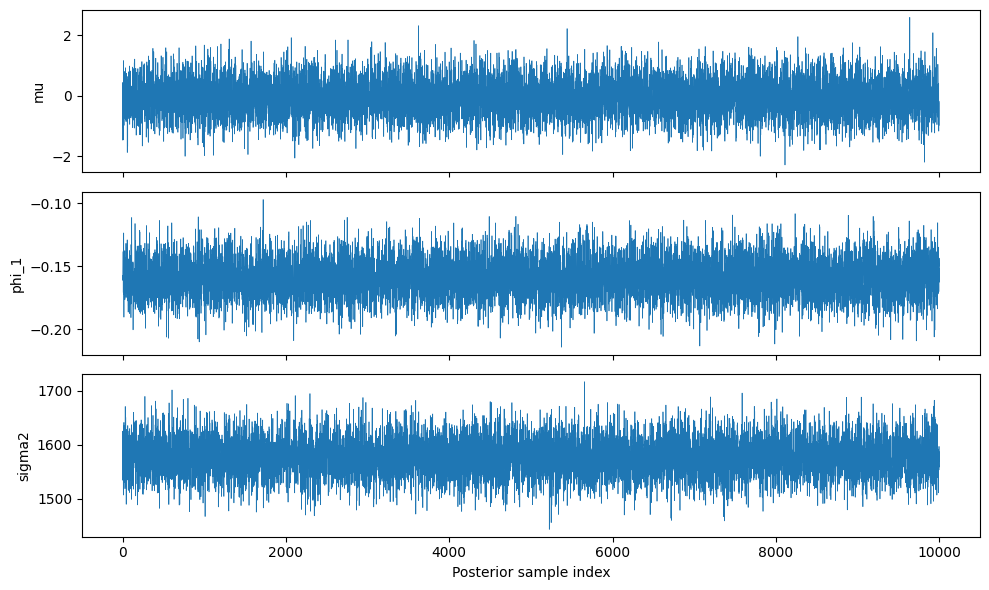

In [11]:
def build_ar_design(y, p):
    """
    Build design matrix X and response vector y_for_reg such that:
    y_for_reg = X @ beta + eps
    where beta = (mu, phi1, ..., phip)
    
    y: 1d numpy array or pandas Series (index ordered by time)
    p: AR order (integer >= 0)
    
    Returns (X, y_reg). X shape = (n_obs - p, p+1), y_reg shape = (n_obs - p,)
    """
    y = pd.Series(y).reset_index(drop=True)  # ensure integer index
    n = len(y)
    if p == 0:
        X = np.ones((n, 1))
        y_reg = y.values.copy()
        return X, y_reg
    rows = []
    for t in range(p, n):
        row = [1.0]  # intercept
        for lag in range(1, p+1):
            row.append(y.iloc[t-lag])
        rows.append(row)
    X = np.array(rows)            # shape (n-p, p+1)
    y_reg = y.iloc[p:].values     # shape (n-p,)
    return X, y_reg

def gibbs_ar_conjugate(df,
                       date_col='date',
                       value_col='pm25',
                       p=1,
                       use_diff=True,
                       n_samples=5000,
                       burn_in=1000,
                       thin=1,
                       beta0=None,
                       V0_diag=100.0,
                       alpha0=2.0,
                       beta0_ig=1.0,
                       random_seed=42,
                       plot_traces=True):
    """
    Fit conjugate Bayesian AR(p) via Gibbs sampling.
    
    Arguments:
    - df: pandas DataFrame with columns date_col and value_col
    - p: AR order (integer)
    - use_diff: if True, uses first-differenced series Δy_t = y_t - y_{t-1}
    - n_samples: number of posterior draws to keep *after* burn-in & thinning
    - burn_in: number of burn-in iterations
    - thin: thinning factor (keep every `thin`-th sample)
    - beta0: prior mean vector for beta (length p+1). If None, zeros.
    - V0_diag: prior diagonal variance for beta (scalar, sets V0 = diag(V0_diag,...))
    - alpha0, beta0_ig: inverse-gamma prior hyperparams (shape, scale) for sigma^2
    - random_seed: RNG seed
    - plot_traces: show simple trace plots for each parameter
    
    Returns:
    dict with keys:
      - 'beta_samples': array (n_draws, p+1)
      - 'sigma2_samples': array (n_draws,)
      - 'posterior_summary': dict with posterior mean and 95% CI
      - 'X', 'y_reg' : design matrix and regression response used
    """
    rng = np.random.default_rng(random_seed)
    
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).set_index(date_col)
    y = df[value_col].astype(float).dropna()
    
    if use_diff:
        y = y.diff().dropna()
    
    # build design matrix for AR(p)
    X, y_reg = build_ar_design(y.values, p)
    n_obs, k = X.shape  # k = p+1
    # default priors
    if beta0 is None:
        beta0 = np.zeros(k)
    beta0 = np.asarray(beta0).reshape(k)
    V0 = np.eye(k) * V0_diag  # prior covariance for beta
    V0_inv = np.linalg.inv(V0)
    
    # Storage and initialization
    total_iters = burn_in + n_samples * thin
    beta_samples = np.zeros((n_samples, k))
    sigma2_samples = np.zeros(n_samples)
    
    # initialize by OLS
    ols_beta = np.linalg.lstsq(X, y_reg, rcond=None)[0]
    resid = y_reg - X.dot(ols_beta)
    sigma2_current = np.var(resid, ddof=k)
    beta_current = ols_beta.copy()
    
    sample_idx = 0
    iter_idx = 0
    
    # Precompute X'X and X'y for speed
    XtX = X.T.dot(X)
    Xty = X.T.dot(y_reg)
    
    for it in range(total_iters):

        precision = V0_inv + (1.0 / sigma2_current) * XtX
        cov_beta = np.linalg.inv(precision)
        mean_beta = cov_beta.dot(V0_inv.dot(beta0) + (1.0 / sigma2_current) * Xty)
        # draw beta
        beta_current = rng.multivariate_normal(mean_beta, cov_beta)
        

        resid = y_reg - X.dot(beta_current)
        alpha_n = alpha0 + n_obs / 2.0
        beta_n = beta0_ig + 0.5 * np.sum(resid**2)
        # scipy invgamma uses shape=a and scale=scale
        sigma2_current = invgamma(a=alpha_n, scale=beta_n).rvs(random_state=rng)
        
        # store after burn-in and respecting thinning
        iter_idx += 1
        if it >= burn_in and ((it - burn_in) % thin == 0):
            beta_samples[sample_idx, :] = beta_current
            sigma2_samples[sample_idx] = sigma2_current
            sample_idx += 1
    
    def ci_95(arr):
        lower = np.percentile(arr, 2.5, axis=0)
        upper = np.percentile(arr, 97.5, axis=0)
        mean = np.mean(arr, axis=0)
        return mean, lower, upper
    
    beta_mean, beta_lo, beta_hi = ci_95(beta_samples)
    sigma2_mean, sigma2_lo, sigma2_hi = ci_95(sigma2_samples)
    
    posterior_summary = {
        'beta_mean': beta_mean,
        'beta_95ci': np.vstack([beta_lo, beta_hi]).T,  # rows for each coef
        'sigma2_mean': sigma2_mean,
        'sigma2_95ci': (sigma2_lo, sigma2_hi)
    }
    
    results = {
        'beta_samples': beta_samples,
        'sigma2_samples': sigma2_samples,
        'posterior_summary': posterior_summary,
        'X': X,
        'y_reg': y_reg,
        'p': p,
        'use_diff': use_diff
    }
    
    if plot_traces:
        param_names = ['mu'] + [f'phi_{i}' for i in range(1, p+1)]
        n_params = k
        fig, axes = plt.subplots(nrows=n_params+1, figsize=(10, 2*(n_params+1)), sharex=True)
        #plt.title("Trace Plots")
        for i in range(n_params):
            axes[i].plot(beta_samples[:, i], lw=0.5)
            axes[i].set_ylabel(param_names[i])
        axes[-1].plot(sigma2_samples, lw=0.5)
        axes[-1].set_ylabel('sigma2')
        axes[-1].set_xlabel('Posterior sample index')
        
        plt.tight_layout()
        plt.show()
    
    return results


results = gibbs_ar_conjugate(train,
                              date_col='date',
                              value_col='pm25',
                              p=1,
                              use_diff=True,
                              n_samples=10000,
                              burn_in=1000,
                              thin=1,
                              V0_diag=100.0,
                              alpha0=2.0,
                              beta0_ig=1.0,
                              plot_traces=True)

#print(results['posterior_summary'])


### 7.4.4 ACF Plots

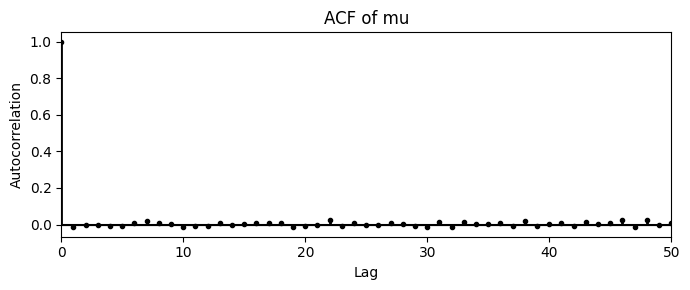

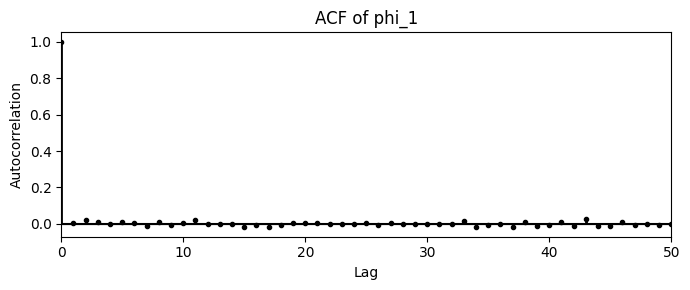

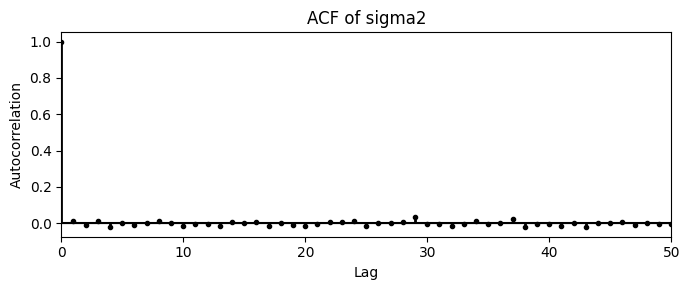

In [41]:
beta_samples = results['beta_samples']
sigma2_samples = results['sigma2_samples']

param_names = ['mu'] + [f'phi_{i}' for i in range(1, beta_samples.shape[1])]
nlags = 50  # change as desired (max lag to show)

def plot_acf_mcmc(chain, param_label, nlags=50):
    chain = np.asarray(chain)
    acf_vals = acf(chain, nlags=nlags, fft=True)
    lags = np.arange(len(acf_vals))

    plt.figure(figsize=(7,3))
    
    markerline, stemlines, baseline = plt.stem(lags, acf_vals)
    plt.setp(markerline, marker='o', markersize=3, color='black')
    plt.setp(stemlines, color='black', linewidth=2)
    plt.setp(baseline, color='black')
    
    # Zero line
    plt.axhline(0, color='black', linewidth=0.8)

    plt.title(f"ACF of {param_label}")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.xlim(0, nlags)
    plt.tight_layout()
    plt.show()

for i, name in enumerate(param_names):
    plot_acf_mcmc(beta_samples[:, i], name, nlags=nlags)

plot_acf_mcmc(sigma2_samples, 'sigma2', nlags=nlags)

Thus, the chain shows good mixing and low autocorrelation.

### 7.4.5 Effective Sample Size (ESS) calculation

$$
\text{ESS} \;\approx\; \frac{N}{1 + 2 \sum_{k=1}^{\infty} \rho_k},
$$

where

- $N$ = number of MCMC iterations  
- $\rho_k$ = autocorrelation at lag $k$

Here, instead of infinite series computation, we threshold the acf and find the sum. We have used threshold=0.001

In [27]:
def ess_threshold(samples, max_lag=100, thr=0.01):
    """
    ESS using a thresholded ACF sum
    """
    rho = acf(samples, nlags=max_lag)            # rho[0] = 1 at lag 0
    rho_pos = rho[1:][rho[1:] >= thr]            # exclude lag 0, keep >= thr
    tau = 1.0 + 2.0 * np.sum(rho_pos)
    ess = len(samples) / tau
    return ess

print (f"ESS for mu chain: {ess_threshold(beta_samples[:, 0])}")
print (f"ESS for phi_1 chain: {ess_threshold(beta_samples[:, 1])}")
print (f"ESS for sigma2 chain: {ess_threshold(sigma2_samples)}")

ESS for mu chain: 6457.30693193858
ESS for phi_1 chain: 6798.694261825198
ESS for sigma2 chain: 7015.388207781306


The ESS values are quite high for each chain, indicating a high quality chain.

### 7.4.4 Model Summary

| Parameter | Posterior Mean | 95% Credible Interval |
|-----------|----------------|------------------------|
| $\mu$ (intercept) | -0.0460 | [-1.2251, 1.1595] |
| $\phi_1$ | -0.1592 | [-0.1884, -0.1290] |
| $\sigma^2$ | 1576.97 | [1509.79, 1645.92] |

## 7.5 Plots
### 7.5.1 Plotting Actual Vs Fitted Values

Now, we can find predicted values of first differenced PM 2.5 concentration values by plugging posterior means into our model.
After that we reconstruct series we want to predict by undifferencing. Post that, we can plot against actual values.

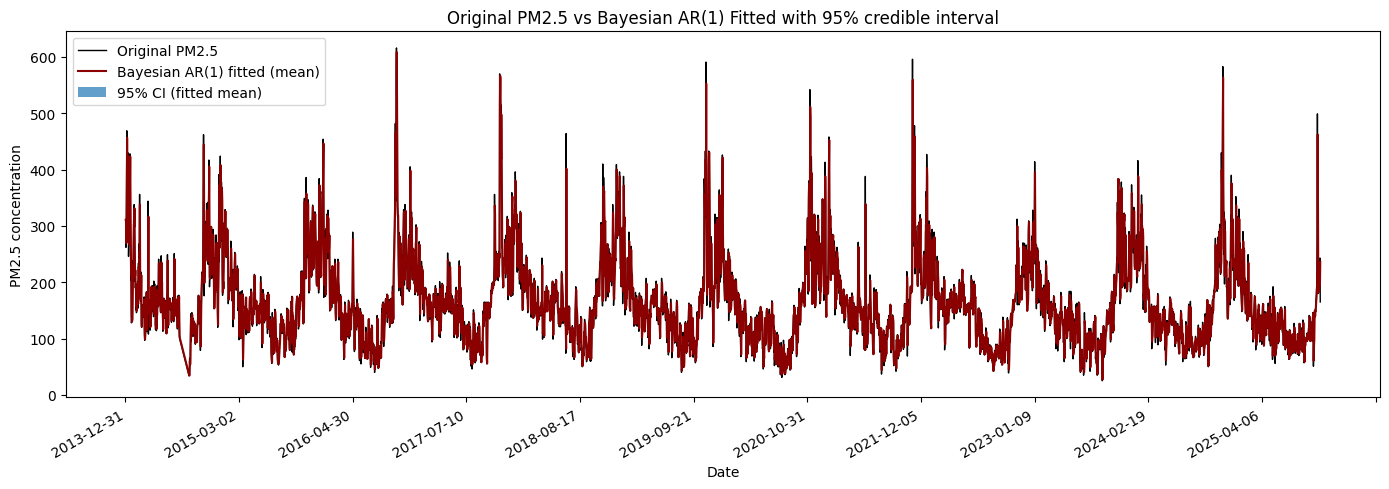

In [45]:
beta_samples = results['beta_samples']        # shape: (n_draws, p)
X = results['X']                              # shape: (n_fitted, p) or pd.DataFrame
y_reg = results['y_reg']
p = results['p']

beta_mean = results['posterior_summary']['beta_mean']
mu_hat, phi1_hat = beta_mean
y_fitted_diff = X.dot(beta_mean)

# --- compute fitted differenced values for each posterior draw ---
# make sure X is a numpy array
if hasattr(X, "values"):
    X_mat = X.values
else:
    X_mat = np.asarray(X)

# beta_samples shape check: expected (n_draws, p)
beta_samples = np.asarray(beta_samples)
if beta_samples.ndim != 2 or beta_samples.shape[1] != X_mat.shape[1]:
    raise ValueError("beta_samples should be shape (n_draws, p) and match X columns.")

# compute matrix of fitted diffs: shape (n_fitted, n_draws)
# X_mat @ beta_samples.T -> (n_fitted, p) @ (p, n_draws) = (n_fitted, n_draws)
y_fitted_diff_samples = X_mat @ beta_samples.T

# compute 2.5% and 97.5% quantiles across draws for each time point
lower_q = np.percentile(y_fitted_diff_samples, 2.5, axis=1)
upper_q = np.percentile(y_fitted_diff_samples, 97.5, axis=1)
mean_q  = np.mean(y_fitted_diff_samples, axis=1)  # alternative to using beta_mean

y_indexed = train.set_index('date')
y_orig = y_indexed['pm25'].sort_index().astype(float)
y_diff_full = y_orig.diff().dropna()
n_fitted = len(y_fitted_diff)
if len(y_diff_full) >= n_fitted:
    fitted_index = y_diff_full.index[-n_fitted:]
else:
    fitted_index = pd.RangeIndex(start=0, stop=n_fitted)

y_fitted_diff_series = pd.Series(y_fitted_diff, index=fitted_index)
y_fitted_diff_mean_series = pd.Series(mean_q, index=fitted_index)
y_fitted_diff_lower = pd.Series(lower_q, index=fitted_index)
y_fitted_diff_upper = pd.Series(upper_q, index=fitted_index)

# --- Reconstruct to original scale: y_hat_t = y_{t-1} + fitted_delta_t ---
y_prev = y_orig.shift(1)
y_prev_aligned = y_prev.reindex(fitted_index)

y_fitted_orig = (y_prev_aligned + y_fitted_diff_series).dropna()
y_fitted_orig_mean = (y_prev_aligned + y_fitted_diff_mean_series).dropna()
y_fitted_orig_lower = (y_prev_aligned + y_fitted_diff_lower).dropna()
y_fitted_orig_upper = (y_prev_aligned + y_fitted_diff_upper).dropna()

common_index = y_fitted_orig.index.intersection(y_fitted_orig_lower.index).intersection(y_fitted_orig_upper.index)

y_plot_orig = y_orig.reindex(y_orig.index)  # full original
y_fitted_plot = y_fitted_orig_mean.reindex(common_index)
y_lower_plot = y_fitted_orig_lower.reindex(common_index)
y_upper_plot = y_fitted_orig_upper.reindex(common_index)

fig, ax = plt.subplots(1, 1, figsize=(14, 5))

ax.plot(y_orig, label='Original PM2.5', color="black", linewidth=1)
ax.plot(y_fitted_plot.index, y_fitted_plot.values, label='Bayesian AR(1) fitted (mean)', color='darkred', linewidth=1.5)

# shaded 95% credible interval
ax.fill_between(y_fitted_plot.index,
                y_lower_plot.values,
                y_upper_plot.values,
                alpha=0.7,
                label='95% CI (fitted mean)',
                edgecolor=None)

ax.set_title('Original PM2.5 vs Bayesian AR(1) Fitted with 95% credible interval')
ax.set_xlabel('Date')
ax.set_ylabel('PM2.5 concentration')
ax.legend()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
plt.tight_layout()
plt.show()


The fit using the posterior means looks very similar to the ARIMA model. It tracks he overall direction of the data very well but has the same drawbacks that it underestimates extremes and has the "shadowing" effect that the ARIMA model had. The advantage that this model has however, is the modelling of the entire posterior distribution allowing for modelling of uncertainty in the fit. 

The credible intervals here are too narrow to show up.

### 7.5.2 Residual Plot

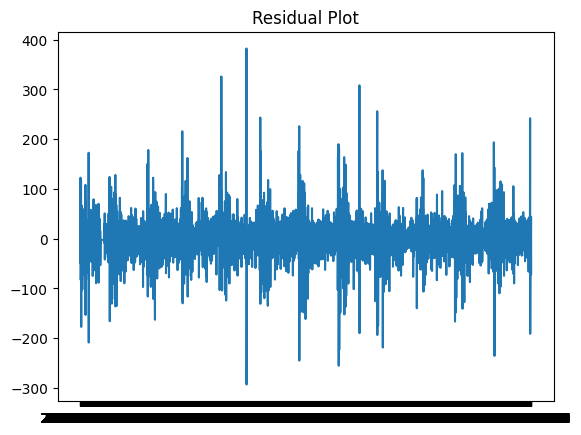

In [37]:
resid = y_orig - y_fitted_orig
plt.plot(resid)
plt.title("Residual Plot")
plt.show()

The residual plot looks near identical to the one for the ARIMA fit.

### 7.5.3 AIC/BIC calculation

The Akaike Information Criterion (AIC) is defined as

$$
\text{AIC} = -2\,\ell(\widehat{\theta}) + 2k,
$$

and the Bayesian Information Criterion (BIC) is defined as

$$
\text{BIC} = -2\,\ell(\widehat{\theta}) + k \,\log(n),
$$

where

- $\ell(\widehat{\theta})$ is the log-likelihood evaluated at the estimated parameters,
- $k$ is the number of estimated parameters in the model,
- $n$ is the number of observations used in the likelihood.

The lower the information criteria for a model, the better, in comparison to another model.

In [40]:
sigma2_hat = results['posterior_summary']['sigma2_mean']   # posterior mean of sigma^2
resid = y_reg - y_fitted_diff                               # residuals on differenced scale
n = len(resid)
loglik = -0.5 * n * np.log(2 * np.pi * sigma2_hat) - 0.5 * np.sum(resid**2) / sigma2_hat

# number of parameters: mu, phi1, sigma2  -> 3
k_params = 3
AIC = -2 * loglik + 2 * k_params
BIC = -2 * loglik + k_params * np.log(n)
print(f"AIC: {AIC:.4f} {'\n'}BIC: {BIC:.4f}")

AIC: 42891.9090 
BIC: 42910.9404


# 7.6 Forecasting

We fit a Bayesian AR(1) model to the first-differenced series

$$
\Delta y_t = \mu + \phi_1 \Delta y_{t-1} + \varepsilon_t,
\qquad
\varepsilon_t \sim \mathcal{N}(0,\sigma^2).
$$

To forecast $H$ steps ahead, we simulate the predictive distribution by drawing from the posterior of 
$(\mu,\phi_1,\sigma^2)$ and, for each posterior draw, iteratively generating future $\Delta y$ values.

1. **Initialize** with the last observed differenced value $\Delta y_T$.

2. **For each step** $h = 1,\dots,H$ and for each posterior draw $s$:

$$
\Delta y_{T+h}^{(s)}
=
\mu^{(s)}
+
\phi_1^{(s)} \Delta y_{T+h-1}^{(s)}
+
\varepsilon_{T+h}^{(s)},
\qquad
\varepsilon_{T+h}^{(s)} \sim \mathcal{N}\big(0,\sigma^{2(s)}\big),
$$

where $(\mu^{(s)},\phi_1^{(s)},\sigma^{2(s)})$ is the $s$-th posterior sample.

3. **Reconstruct forecasts on the original scale** using

$$
y_{T+h}^{(s)}
=
y_{T+h-1}^{(s)}
+
\Delta y_{T+h}^{(s)},
$$

starting from the last observed original value $y_T$.

By repeating this simulation for many posterior draws, we obtain a Monte Carlo approximation to the full
posterior predictive distribution. From these predictive samples we compute summary quantities such as the
predictive mean, median, and credible intervals for each forecast horizon.


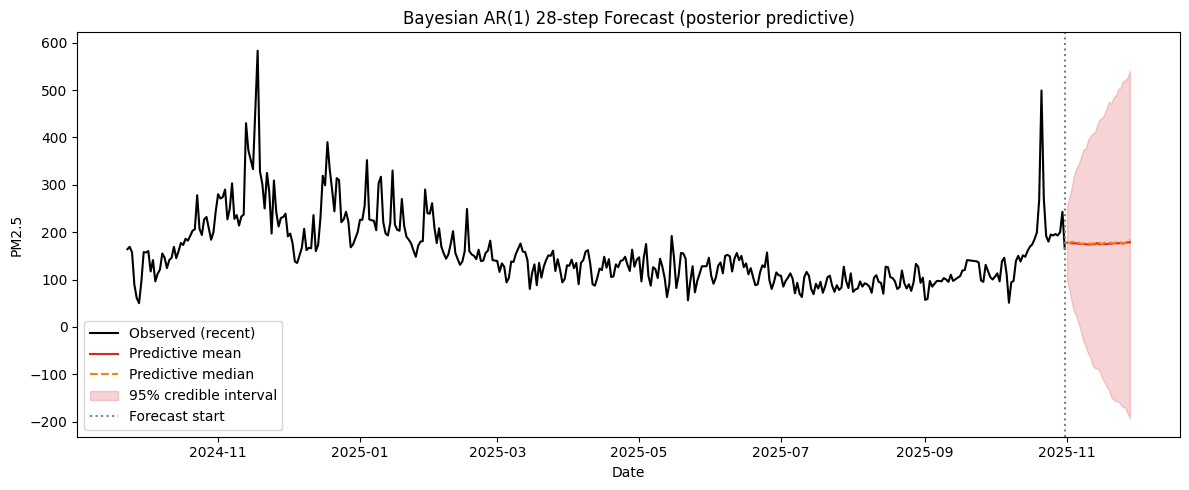

In [ ]:
H = 28                    # forecast horizon (days). 
max_draws = 2000          # max number of posterior draws to use for simulation (cap for speed)
random_seed = 12345

beta_samples = np.asarray(results['beta_samples'])    # shape (S, 2) [mu, phi1]
sigma2_samples = np.asarray(results['sigma2_samples']) # shape (S,)

S_total = beta_samples.shape[0]
S = min(S_total, max_draws)

rng = np.random.default_rng(random_seed)

# if we cap draws, randomly choose S draws from posterior to avoid bias
if S < S_total:
    idx = rng.choice(S_total, size=S, replace=False)
    beta_draws = beta_samples[idx, :]
    sigma2_draws = sigma2_samples[idx]
else:
    beta_draws = beta_samples
    sigma2_draws = sigma2_samples

# prepare last observed values from original series
train_local = train.copy()
train_local['date'] = pd.to_datetime(train_local['date'])
train_local = train_local.sort_values('date').reset_index(drop=True)
y_orig = train_local.set_index('date')['pm25'].astype(float)

# last observed original value and last observed diff
y_T = float(y_orig.iloc[-1])
y_diff_full = y_orig.diff().dropna()
if len(y_diff_full) == 0:
    raise RuntimeError("Differenced series is empty; cannot forecast. Check your data.")
delta_T = float(y_diff_full.iloc[-1])   # Δy_T

# infer frequency for creating future dates; fallback to 'D' (daily)
freq = pd.infer_freq(y_orig.index)
if freq is None:
    # fallback to daily
    freq = 'D'

last_date = y_orig.index[-1]
future_index = pd.date_range(start=last_date + pd.Timedelta(1, unit=freq[0]) if freq is not None else last_date + pd.Timedelta(1, unit='D'),
                             periods=H, freq=freq)

# We simulate one path per posterior draw (S paths). For each draw, simulate H steps forward.
sim_y = np.zeros((S, H))   # original-scale forecasts
sim_delta = np.zeros((S, H))  # differenced forecasts (optional)

for s in range(S):
    mu_s, phi1_s = beta_draws[s]
    sigma_s = np.sqrt(sigma2_draws[s])
    delta_prev = delta_T
    y_prev = y_T
    for h in range(H):
        eps = rng.normal(loc=0.0, scale=sigma_s)
        delta_h = mu_s + phi1_s * delta_prev + eps
        y_h = y_prev + delta_h

        sim_delta[s, h] = delta_h
        sim_y[s, h] = y_h

        # update for next step
        delta_prev = delta_h
        y_prev = y_h

pred_mean = sim_y.mean(axis=0)
pred_median = np.median(sim_y, axis=0)
pred_lower = np.percentile(sim_y, 2.5, axis=0)
pred_upper = np.percentile(sim_y, 97.5, axis=0)

forecast_df = pd.DataFrame({
    'date': future_index,
    'mean': pred_mean,
    'median': pred_median,
    'lower_95': pred_lower,
    'upper_95': pred_upper
}).set_index('date')



plt.figure(figsize=(12,5))
# plot last chunk of observed data for context (e.g., last 200 points)
plot_n = min(len(y_orig), 400)
y_plot = y_orig.iloc[-plot_n:]
plt.plot(y_plot.index, y_plot.values, color='black', label='Observed (recent)')

# plot posterior predictive mean and median
plt.plot(forecast_df.index, forecast_df['mean'], color='tab:red', label='Predictive mean')
plt.plot(forecast_df.index, forecast_df['median'], color='tab:orange', linestyle='--', label='Predictive median')

# credible interval band
plt.fill_between(forecast_df.index, forecast_df['lower_95'], forecast_df['upper_95'],
                    color='tab:red', alpha=0.2, label='95% credible interval')

plt.axvline(y_plot.index[-1], color='gray', linestyle=':', label='Forecast start')
plt.title(f'Bayesian AR(1) {H}-step Forecast (posterior predictive)')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()
plt.tight_layout()
plt.show()

out = {
    'sim_y': sim_y,                 # (S, H) simulated original-scale forecasts
    'sim_delta': sim_delta,         # (S, H) simulated differenced forecasts
    'forecast_df': forecast_df,     # summary table
    'beta_draws': beta_draws,
    'sigma2_draws': sigma2_draws,
    'H': H
}


The forecast is also equally as bad as in teh case of the ARIMA model.

# 8. Conclusion

This project developed and evaluated both classical and Bayesian approaches for modeling and forecasting PM2.5 concentrations. After transforming the series to stationarity through first differencing, exploratory analysis indicated that an AR(1) structure was the most appropriate, based on the sharp PACF cutoff at lag 1. A classical ARIMA model served as the baseline and demonstrated a strong in-sample fit, effectively capturing the persistence and variability in the PM2.5 series.

Building on this, we implemented a Bayesian AR(1) (BAR) model using conjugate Normal–Inverse-Gamma priors and a Gibbs sampling algorithm. The Bayesian formulation produced full posterior distributions for the autoregressive coefficient, intercept, and variance, enabling uncertainty quantification beyond what classical ARIMA provides. Diagnostic tools—including ACF plots and effective sample size (ESS) calculations—showed that the sampler mixed well and that posterior estimates were stable and reliable.

When reconstructed to the original scale, the BAR model’s fitted values closely matched those from the baseline ARIMA model, achieving equivalent predictive performance while offering richer probabilistic information. Posterior predictive simulations produced meaningful short-term forecasts with credible intervals, demonstrating the practical value of Bayesian inference for environmental monitoring and risk assessment.

Overall, the Bayesian AR framework performed just as well as the classical ARIMA model in terms of point prediction, while providing significant advantages in transparency, interpretability, and uncertainty quantification. This makes the Bayesian approach particularly well-suited for decision-making contexts where understanding forecast uncertainty is as important as the forecasts themselves.